# Week 9 Problem Set

## Cohort Session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**CS0.** *Plot:* Read data for Boston Housing Prices and write a function `get_features_targets()` to get the columns for the features and the targets from the input argument data frame. The function should take in Pandas' dataframe and two lists. The first list is for the feature names and the other list is for the target names. 

We will use the following columns for our test cases:
- x data: RM column - use z normalization (standardization)
- y data: MEDV column

**Make sure you return a new data frame for both the features and the targets.**

We will normalize the feature using z normalization. Plot the data using scatter plot. 



In [3]:
def normalize_z(dfin: pd.DataFrame, columns_means: pd.Series | None = None, columns_stds: pd.Series | None = None):
    if columns_means == None:
        columns_means = dfin.mean(axis=0)
    if columns_stds == None: 
        # columns_stds is given as opt arg because if dfin only contains 1 sample (1 row), then dfin.std(axis=0) will be 0 and dfout will be error
        columns_stds = dfin.std(axis=0)
    dfout = (dfin - columns_means) / columns_stds
    return dfout, columns_means, columns_stds

In [4]:
def get_features_targets(df, feature_names, target_names):
    return df[feature_names], df[target_names]

In [5]:
df = pd.read_csv("housing_processed.csv")
df_feature, df_target = get_features_targets(df,["RM"],["MEDV"])
df_feature,_,_ = normalize_z(df_feature)

assert isinstance(df_feature, pd.DataFrame)
assert isinstance(df_target, pd.DataFrame)
assert np.isclose(df_feature.mean(), 0.0)
assert np.isclose(df_feature.std(), 1.0)
assert np.isclose(df_target.mean(), 22.532806)
assert np.isclose(df_target.std(), 9.1971)


In [6]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


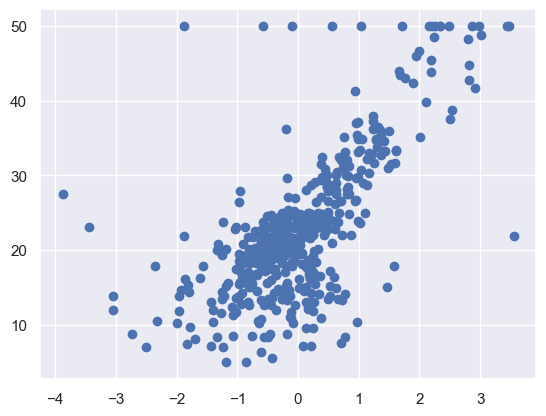

In [7]:
sns.set()
plt.scatter(df_feature, df_target)

**CS1.** *Cost Function:* Write a function `compute_cost_linreg()` to compute the cost function of a linear regression model. The function should take in two 2-D numpy arrays. The first one is the matrix of the linear equation and the second one is the actual target value.

Recall that:

$$J(\hat{\beta}_0, \hat{\beta}_1) = \frac{1}{2m}\Sigma^m_{i=1}\left(\hat{y}(x^i)-y^i\right)^2$$

where

$$\hat{y}(x^i) = \hat{\beta}_0 + \hat{\beta}_1 x^i$$

The function should receive a numpy array, so we will need to convert to numpy array and change the shape. To do this, we will create three other functions:
- `calc_linreg(X, b)`: which is used to calculate the $\hat{y} = Xb$ vector.
- `prepare_feature(df)`: which takes in a data frame or two-dimensional numpy array for the feature. If the input is a data frame, the function should convert the data frame to a numpy array and change it into a column vector. The function should also add a column of constant 1s in the first column.
- `prepare_target(df)`: which takes in a data frame or two-dimensional numpy array for the target. If the input is a data frame, the function should simply convert the data frame to a numpy array and change it into column vectors. **The function should be able to handle if the data frame or the numpy array have more than one column.**

You can use the following methods in your code:
- `df.to_numpy()`: which is to convert a Pandas data frame to Numpy array.
- `np.reshape(row, col)`: which is to reshape the numpy array to a particular shape.
- `np.concatenate((array1, array2), axis)`: which is to join a sequence of arrays along an existing axis.
- `np.matmul(array1, array2)`: which is to do matrix multiplication on two Numpy arrays.


In [53]:
def prepare_target(df_target: pd.DataFrame | np.ndarray | pd.Series):
    try:
        cols = df_target.shape[1] # df_target.shape returns a tuple #row,#col, i'm expecting 1 here at Week 9
    except IndexError:
        cols = 1
    # check if df_target is a dataframe? 
    if isinstance(df_target, pd.DataFrame):
        # if yes, convert to numpy using the to_numpy() func from Pandas
        np_target = df_target.to_numpy()
    elif isinstance(df_target, pd.Series):
        np_target = df_target.to_numpy()
    elif isinstance(df_target, np.ndarray):
        # by definition, if arg is not a DF, it will be a numpy array
        np_target = df_target 
    return np_target.reshape(-1, cols) 
    

In [9]:
def prepare_feature(df_feature: pd.DataFrame | np.ndarray):
    res = prepare_target(df_feature)
    return np.insert(res, 0, 1, axis=1)


test_a = np.array(
    [
        [1, 2, 3],
        [2, 2, 3],
        [3, 2, 3]
    ]
)
print(np.ones((test_a.shape[0], 1)))
prepare_feature(test_a)

[[1.]
 [1.]
 [1.]]


array([[1, 1, 2, 3],
       [1, 2, 2, 3],
       [1, 3, 2, 3]])

In [10]:
def calc_linreg(X: np.ndarray, beta: np.ndarray) -> np.ndarray:
    return X @ beta

In [11]:
def compute_cost_linreg(X: np.ndarray, actual_y: np.ndarray, beta: np.ndarray):
    n_samples = X.shape[0]
    predicted_y = calc_linreg(X, beta)
    error = predicted_y - actual_y

    J = 1 / (2 * n_samples) * (error.transpose() @ error)
    return J[0, 0]


In [12]:
X = prepare_feature(df_feature)
target = prepare_target(df_target)

assert isinstance(X, np.ndarray)
assert isinstance(target, np.ndarray)
assert X.shape == (506, 2)
assert target.shape == (506, 1)

In [13]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


In [14]:
# print(X)
beta = np.zeros((2,1))
J = compute_cost_linreg(X, target, beta)
print(J)
assert np.isclose(J, 296.0735)

beta = np.ones((2,1))
J = compute_cost_linreg(X, target, beta)
print(J)
assert np.isclose(J, 268.157)

beta = np.array([-1, 2]).reshape((2,1))
J = compute_cost_linreg(X, target, beta)
print(J)
assert np.isclose(J, 308.337)


296.07345849802374
268.1570051486897
308.33699448710274


In [15]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


**CS2.** *Gradient Descent:* Write a function called `gradient_descent_linreg()` that takes in these parameters:
- `X`: is a 2-D numpy array for the features
- `y`: is a vector array for the target
- `beta`: is a column vector for the initial guess of the parameters
- `alpha`: is the learning rate
- `num_iters`: is the number of iteration to perform

The function should return two numpy arrays:
- `beta`: is coefficient at the end of the iteration
- `J_storage`: is the array that stores the cost value at each iteration

You can use some of the following functions:
- `calc_linreg(X, b)`: which is used to calculate $y = Xb$ vector.
- `np.matmul(array1, array2)`: which is to do matrix multiplication on two Numpy arrays.
- `compute_cost_linreg()`: which the function you created in the previous problem set to compute the cost.

In [16]:
def gradient_descent_linreg(
        X: np.ndarray,
        actual_y: np.ndarray, 
        beta: np.ndarray, 
        learning_rate: float, 
        num_iters: int):
    n_samples = X.shape[0]
    J_storage = np.zeros((num_iters, 1))
    for i in range(num_iters):
        predicted_y = calc_linreg(X, beta)
        gradient = X.T @ (predicted_y - actual_y)
        beta = beta - learning_rate / n_samples * gradient
        J_storage[i] = compute_cost_linreg(X, actual_y, beta)
    return beta, J_storage

In [17]:
iterations = 1500
learning_rate = 0.01
beta = np.zeros((2,1))

beta, J_storage = gradient_descent_linreg(X, target, beta, learning_rate, iterations)
print(beta)
assert np.isclose(beta[0], 22.5328)
assert np.isclose(beta[1], 6.3953)

[[22.53279993]
 [ 6.39529594]]


In [18]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


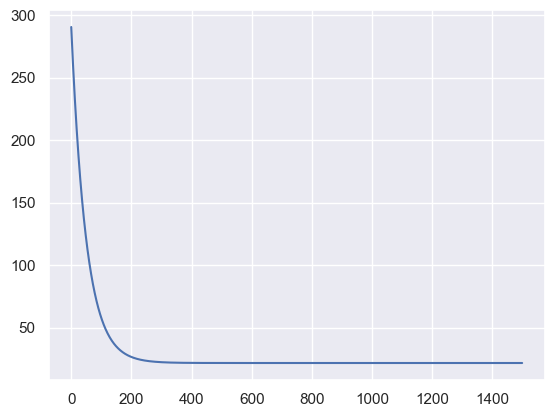

In [19]:
plt.plot(J_storage)

**CS3.** *Predict:* Write the function `predict_linreg()` that calculates the straight line equation given the features and its coefficient.
- `predict_linreg()`: this function should standardize the feature using z normalization, change it to a Numpy array, and add a column of constant 1s. You should use `prepare_feature()` for this purpose. Lastly, this function should also call `calc_linreg()` to get the predicted y values.

You can use some of the following functions:
- `calc_linreg(X, beta)`: which is used to calculate the predicted y after X has been normalized and added by a constant.
- `np.matmul(array1, array2)`: which is to do matrix multiplication on two Numpy arrays.
- `normalize_z(df)`: which is to do z normalization on the data frame.

In [20]:
def predict_linreg(df_feature, beta, means=None, stds=None):
    """
    * beta: a column vector of beta_0 and beta_1.
    """
    normalized, _, _ = normalize_z(df_feature, means, stds)
    prepared = prepare_feature(normalized)
    return prepared @ beta

In [21]:
df_feature, buf = get_features_targets(df, ["RM"], [])
# print(df_feature)
beta = [[22.53279993],[ 6.39529594]] # from previous result
pred = predict_linreg(df_feature, beta)

assert isinstance(pred, np.ndarray)
assert pred.shape == (506, 1)
assert np.isclose(pred.mean(), 22.5328)
assert np.isclose(pred.std(), 6.38897)

In [22]:
means = [6.284634]
stds = [0.702617]
beta = [[22.53279993],[ 6.39529594]] # from previous result
input_1row = np.array([[6.593]])
pred_1row = predict_linreg(input_1row, beta, means, stds)
assert np.isclose(pred_1row[0][0], 25.33958)

In [23]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


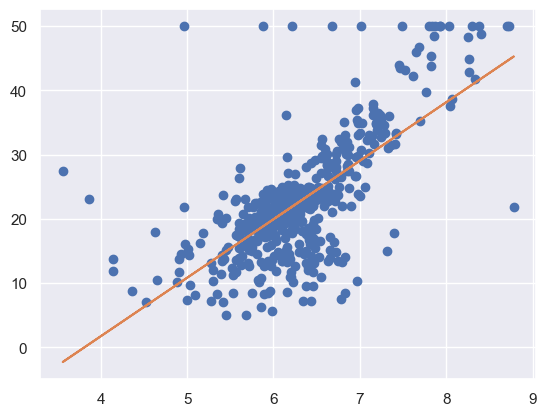

In [24]:
plt.plot(df_feature["RM"],target,'o')
plt.plot(df_feature["RM"],pred,'-')

**CS4.** *Splitting data:* Do the following tasks:
- Read RM as the feature and MEDV as the target from the data frame.
- Use Week 9's function `split_data()` to split the data into train and test using `random_state=100` and `test_size=0.3`. 
- Normalize and prepare the features and the target.
- Use the training data set and call `gradient_descent_linreg()` to obtain the `theta`.
- Use the test data set to get the predicted values.

You need to replace the `None` in the code below with other a function call or any other Python expressions. 

In [71]:
def split_data(df_feature: pd.DataFrame, df_target, random_state=None, test_size=0.3):
    np.random.seed(random_state)

    # generate randomized mask (i.e. list[True|False])
    # test_mask = np.concatenate([
    #     np.ones(int(len(df_feature) * test_size), dtype=bool),
    #     np.zeros(len(df_feature) - int(len(df_feature) * test_size), dtype=bool)
    # ])
    # np.random.shuffle(test_mask)

    test_indexes = np.random.choice(df_feature.index, int(len(df_feature) * test_size), replace=False)

    feature_indexes = [index for index in df_feature.index if index not in test_indexes]

    # print(test_indexes)

    df_feature_train = df_feature.loc[feature_indexes]
    df_feature_test  = df_feature.loc[test_indexes]
    df_target_train  = df_target.loc[feature_indexes]
    df_target_test   = df_target.loc[test_indexes]

    # df_feature_train = df_feature.loc[~test_mask]
    # df_feature_test  = df_feature.loc[test_mask]
    # df_target_train  = df_target.loc[~test_mask]
    # df_target_test   = df_target.loc[test_mask]

    return df_feature_train, df_feature_test, df_target_train, df_target_test
    

In [72]:
# get features and targets from data frame
df_feature, df_target = (df["RM"], df["MEDV"])

# split the data into training and test data sets
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)

# normalize the feature using z normalization
df_feature_train_z, _, _ = normalize_z(df_feature_train)

print(type(df_feature_train_z))

X = prepare_feature(df_feature_train_z)
target = prepare_target(df_target_train)

iterations = 1500
learning_rate = 0.01
beta = np.zeros((2, 1))

print(beta.shape)

# call the gradient_descent function
beta, J_storage = gradient_descent_linreg(X, target, beta, learning_rate, iterations)

# call the predict method to get the predicted values
pred = predict_linreg(df_feature_test, beta)

###
### YOUR CODE HERE
###


<class 'pandas.core.series.Series'>
(2, 1)


In [73]:

assert isinstance(pred, np.ndarray)
assert pred.shape == (151, 1)
display(pd.DataFrame(pred).describe())
assert np.isclose(pred.mean(), 22.66816)
assert np.isclose(pred.std(), 6.257265)


,0
count,151.000000
mean,22.668163
std,6.278087
min,4.620401
25%,19.031242
50%,21.817816
75%,25.436061
max,46.270840


In [27]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


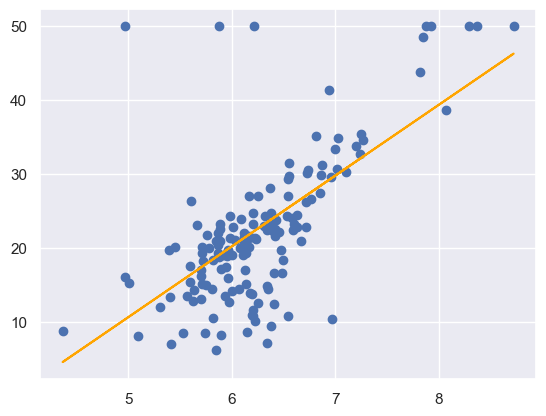

In [74]:
plt.scatter(df_feature_test, df_target_test)
plt.plot(df_feature_test, pred, color="orange")

**CS5.** *R2 Coefficient of Determination:* Write a function to calculate the coefficient of determination as given by the following equations.

$$r^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

where

$$SS_{res} = \Sigma_{i=1}^n (y_i - \hat{y}_i)^2$$ 

where $y_i$ is the actual target value and $\hat{y}_i$ is the predicted target value.

$$SS_{tot} = \Sigma_{i=1}^n (y_i - \overline{y})^2$$

where 
$$ \overline{y} = \frac{1}{n} \Sigma_{i=1}^n y_i$$
and $n$ is the number of target values.

You can use the following functions in your code:
- `np.mean(array)`: which is to get the mean of the array. You can also call it using `array.mean()`.
- `np.sum(array)`: which is to sum the array along a default axis. You can specify which axis to perform the summation.

In [78]:
def r2_score(y: np.ndarray, ypred):
    ss_res = sum((y_i - ypred_i)**2 for y_i, ypred_i in zip(y, ypred))
    ss_tot = sum((y_i - y.mean())**2 for y_i in y)
    return 1 - ss_res / ss_tot

In [79]:
target = prepare_target(df_target_test)
r2 = r2_score(target, pred)
print(r2)
assert np.isclose(r2, 0.45398)

[0.45398075]


In [31]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


**CS6.** *Mean Squared Error:* Create a function to calculate the MSE as given below.

$$MSE = \frac{1}{n}\Sigma_{i=1}^n(y_i - \hat{y}_i)^2$$


In [80]:
def mean_squared_error(target, pred):
    return 1/len(target) * sum((y_i - yhat_i)**2 for y_i, yhat_i in zip(target, pred))

In [81]:
mse = mean_squared_error(target, pred)
print(mse)
assert np.isclose(mse, 53.6375)

[53.63748803]


In [34]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


**CS7.** *Optional:* Redo the above tasks using Sci-kit learn libraries. You will need to use the following:
- [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
- [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- [r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)
- [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [36]:
# Read the CSV and extract the features
df = None
df_feature, df_target = None, None
# normalize
df_feature = None

###
### YOUR CODE HERE
###


In [37]:
# Split the data into training and test data set using scikit-learn function
df_feature_train, df_feature_test, df_target_train, df_target_test = None, None, None, None

# Instantiate LinearRegression() object
model = None

# Call the fit() method
pass

###
### YOUR CODE HERE
###

print(model.coef_, model.intercept_)
assert np.isclose(model.coef_,[6.05090511])
assert np.isclose(model.intercept_, 22.52999668)

In [38]:
# Call the predict() method
pred = None

###
### YOUR CODE HERE
###

print(type(pred), pred.mean(), pred.std())
assert isinstance(pred, np.ndarray)
assert np.isclose(pred.mean(), 22.361699)
assert np.isclose(pred.std(), 5.7011267)

In [39]:
plt.scatter(df_feature_test, df_target_test)
plt.plot(df_feature_test, pred, color="orange")

In [40]:
r2 = r2_score(df_target_test, pred)
print(r2)
assert np.isclose(r2, 0.457647)

In [41]:
mse = mean_squared_error(df_target_test, pred)
print(mse)
assert np.isclose(mse, 54.93216)